In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Build an LLM from Scratch - Part I: Synthèse

## Objectif du workshop
Implémenter et comprendre les blocs fondamentaux des modèles de langage modernes:
1. Self-Attention
2. Multi-Head Attention
3. Positional Encoding
4. Transformer Encoder Block

Ce notebook synthétise tous les concepts et crée un mini-LLM fonctionnel.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from collections import Counter

# Configuration
torch.manual_seed(42)
np.random.seed(42)

print("✓ Bibliothèques importées")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

✓ Bibliothèques importées
PyTorch version: 2.7.1+cu118
Device: CUDA


## 1. Architecture complète du Transformer

In [4]:
# ========== 1. SCALED DOT-PRODUCT ATTENTION ==========
def scaled_dot_product_attention(Q, K, V, mask=None):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores + mask
    attention = F.softmax(scores, dim=-1)
    output = torch.matmul(attention, V)
    return output, attention

# ========== 2. MULTI-HEAD ATTENTION ==========
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.qkv_layer = nn.Linear(d_model, 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.size()
        qkv = self.qkv_layer(x)
        qkv = qkv.reshape(batch_size, seq_len, self.num_heads, 3 * self.d_k)
        qkv = qkv.permute(0, 2, 1, 3)
        Q, K, V = qkv.chunk(3, dim=-1)
        values, attention = scaled_dot_product_attention(Q, K, V, mask)
        values = values.permute(0, 2, 1, 3).reshape(batch_size, seq_len, d_model)
        output = self.linear_layer(values)
        return output, attention

# ========== 3. LAYER NORMALIZATION ==========
class LayerNormalization(nn.Module):
    def __init__(self, d_model, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
    
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

# ========== 4. FEED-FORWARD NETWORK ==========
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

# ========== 5. POSITIONAL ENCODING ==========
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                            (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:x.size(1), :].unsqueeze(0)

# ========== 6. ENCODER BLOCK ==========
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = LayerNormalization(d_model)
        self.ffn = PositionWiseFeedForward(d_model, d_ff, dropout)
        self.norm2 = LayerNormalization(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        attn_output, attention = self.attention(x, mask)
        x = self.norm1(x + self.dropout1(attn_output))
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout2(ffn_output))
        return x, attention

# ========== 7. ENCODER COMPLET ==========
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, 
                 max_len=5000, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model
    
    def forward(self, x, mask=None):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)
        
        attentions = []
        for layer in self.layers:
            x, attention = layer(x, mask)
            attentions.append(attention)
        
        return x, attentions

print("✓ Toutes les classes Transformer définies")

✓ Toutes les classes Transformer définies


## 2. Mini-LLM pour classification de texte

In [5]:
class MiniLLM(nn.Module):
    """
    Mini Language Model basé sur Transformer Encoder
    """
    def __init__(self, vocab_size, d_model=256, num_heads=8, d_ff=1024, 
                 num_layers=4, num_classes=2, dropout=0.1):
        super().__init__()
        
        self.encoder = TransformerEncoder(
            vocab_size=vocab_size,
            d_model=d_model,
            num_heads=num_heads,
            d_ff=d_ff,
            num_layers=num_layers,
            dropout=dropout
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )
    
    def forward(self, x, return_attentions=False):
        """
        Args:
            x: (batch_size, seq_len) token indices
            return_attentions: if True, return attention weights
        """
        # Encoder
        encoded, attentions = self.encoder(x)
        
        # Global average pooling
        pooled = encoded.mean(dim=1)
        
        # Classification
        logits = self.classifier(pooled)
        
        if return_attentions:
            return logits, attentions
        return logits
    
    def predict(self, x):
        """Prédiction avec probabilités"""
        logits = self.forward(x)
        probs = F.softmax(logits, dim=-1)
        preds = probs.argmax(dim=-1)
        return preds, probs

print("✓ MiniLLM défini")

✓ MiniLLM défini


## 3. Données d'exemple (toy dataset)

In [6]:
# Dataset simple pour démonstration
toy_sentences = [
    "this movie is great",
    "i love this film",
    "amazing performance",
    "wonderful story",
    "best movie ever",
    "terrible movie",
    "worst film ever",
    "boring story",
    "bad performance",
    "waste of time"
]

# Labels: 0 = négatif, 1 = positif
toy_labels = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

# Création d'un vocabulaire simple
all_words = ' '.join(toy_sentences).split()
vocab = ['<PAD>', '<UNK>'] + sorted(set(all_words))
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

print(f"Vocabulaire ({len(vocab)} mots): {vocab[:15]}...")
print(f"\nExemples:")
for sent, label in zip(toy_sentences[:3], toy_labels[:3]):
    print(f"  '{sent}' → {'Positif' if label == 1 else 'Négatif'}")

# Tokenization
def tokenize(sentence, word_to_idx, max_len=10):
    tokens = [word_to_idx.get(word, word_to_idx['<UNK>']) 
              for word in sentence.split()]
    # Padding
    if len(tokens) < max_len:
        tokens += [word_to_idx['<PAD>']] * (max_len - len(tokens))
    else:
        tokens = tokens[:max_len]
    return torch.tensor(tokens)

# Préparation des données
max_len = 10
X = torch.stack([tokenize(sent, word_to_idx, max_len) for sent in toy_sentences])
y = torch.tensor(toy_labels)

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nExemple tokenizé: {X[0]}")
print(f"Mots: {[idx_to_word[idx.item()] for idx in X[0] if idx.item() != 0]}")

Vocabulaire (22 mots): ['<PAD>', '<UNK>', 'amazing', 'bad', 'best', 'boring', 'ever', 'film', 'great', 'i', 'is', 'love', 'movie', 'of', 'performance']...

Exemples:
  'this movie is great' → Positif
  'i love this film' → Positif
  'amazing performance' → Positif

X shape: torch.Size([10, 10])
y shape: torch.Size([10])

Exemple tokenizé: tensor([17, 12, 10,  8,  0,  0,  0,  0,  0,  0])
Mots: ['this', 'movie', 'is', 'great']


## 4. Création et test du modèle

In [7]:
# Créer le modèle
model = MiniLLM(
    vocab_size=len(vocab),
    d_model=64,
    num_heads=4,
    d_ff=256,
    num_layers=2,
    num_classes=2
)

print("=== Architecture du modèle ===")
print(model)

# Compter les paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n=== Paramètres ===")
print(f"Total: {total_params:,}")
print(f"Entraînables: {trainable_params:,}")

# Test forward pass
with torch.no_grad():
    logits, attentions = model(X, return_attentions=True)
    preds, probs = model.predict(X)

print(f"\n=== Test forward pass ===")
print(f"Logits shape: {logits.shape}")
print(f"Predictions shape: {preds.shape}")
print(f"Nombre de cartes d'attention: {len(attentions)}")
print(f"Shape de chaque carte: {attentions[0].shape}")

=== Architecture du modèle ===
MiniLLM(
  (encoder): TransformerEncoder(
    (embedding): Embedding(22, 64)
    (pos_encoding): PositionalEncoding()
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderBlock(
        (attention): MultiHeadAttention(
          (qkv_layer): Linear(in_features=64, out_features=192, bias=True)
          (linear_layer): Linear(in_features=64, out_features=64, bias=True)
        )
        (norm1): LayerNormalization()
        (ffn): PositionWiseFeedForward(
          (linear1): Linear(in_features=64, out_features=256, bias=True)
          (linear2): Linear(in_features=256, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm2): LayerNormalization()
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1

## 5. Entraînement rapide (mini-exemple)

Epoch 10/50 - Loss: 0.6222, Acc: 0.8000
Epoch 20/50 - Loss: 0.2540, Acc: 1.0000
Epoch 30/50 - Loss: 0.0520, Acc: 1.0000
Epoch 40/50 - Loss: 0.0120, Acc: 1.0000
Epoch 50/50 - Loss: 0.0040, Acc: 1.0000


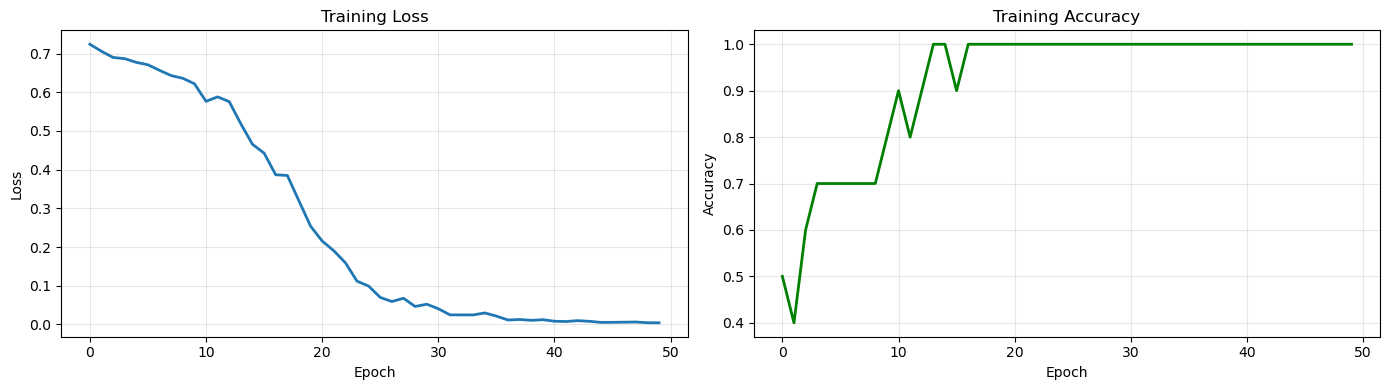


✓ Entraînement terminé!
Perte finale: 0.0040
Précision finale: 1.0000


In [8]:
# Configuration d'entraînement
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entraînement simple
num_epochs = 50
losses = []
accuracies = []

model.train()
for epoch in range(num_epochs):
    # Forward
    logits = model(X)
    loss = criterion(logits, y)
    
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Metrics
    with torch.no_grad():
        preds = logits.argmax(dim=-1)
        acc = (preds == y).float().mean()
    
    losses.append(loss.item())
    accuracies.append(acc.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.4f}, Acc: {acc.item():.4f}")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(losses, linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(accuracies, linewidth=2, color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training Accuracy')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Entraînement terminé!")
print(f"Perte finale: {losses[-1]:.4f}")
print(f"Précision finale: {accuracies[-1]:.4f}")

## 6. Visualisation des prédictions

In [9]:
model.eval()
with torch.no_grad():
    preds, probs = model.predict(X)

print("=== Prédictions ===")
print(f"{'Phrase':<25} {'Vrai':<10} {'Prédit':<10} {'Confiance':<10}")
print("-" * 60)

for i, sent in enumerate(toy_sentences):
    true_label = 'Positif' if y[i] == 1 else 'Négatif'
    pred_label = 'Positif' if preds[i] == 1 else 'Négatif'
    confidence = probs[i, preds[i]].item()
    
    correct = '✓' if y[i] == preds[i] else '✗'
    print(f"{sent:<25} {true_label:<10} {pred_label:<10} {confidence:.2%}  {correct}")

accuracy = (preds == y).float().mean()
print(f"\nPrécision globale: {accuracy:.2%}")

=== Prédictions ===
Phrase                    Vrai       Prédit     Confiance 
------------------------------------------------------------
this movie is great       Positif    Positif    99.70%  ✓
i love this film          Positif    Positif    99.70%  ✓
amazing performance       Positif    Positif    99.70%  ✓
wonderful story           Positif    Positif    99.70%  ✓
best movie ever           Positif    Positif    99.71%  ✓
terrible movie            Négatif    Négatif    99.78%  ✓
worst film ever           Négatif    Négatif    99.78%  ✓
boring story              Négatif    Négatif    99.78%  ✓
bad performance           Négatif    Négatif    99.78%  ✓
waste of time             Négatif    Négatif    99.77%  ✓

Précision globale: 100.00%


## 7. Visualisation des attention maps

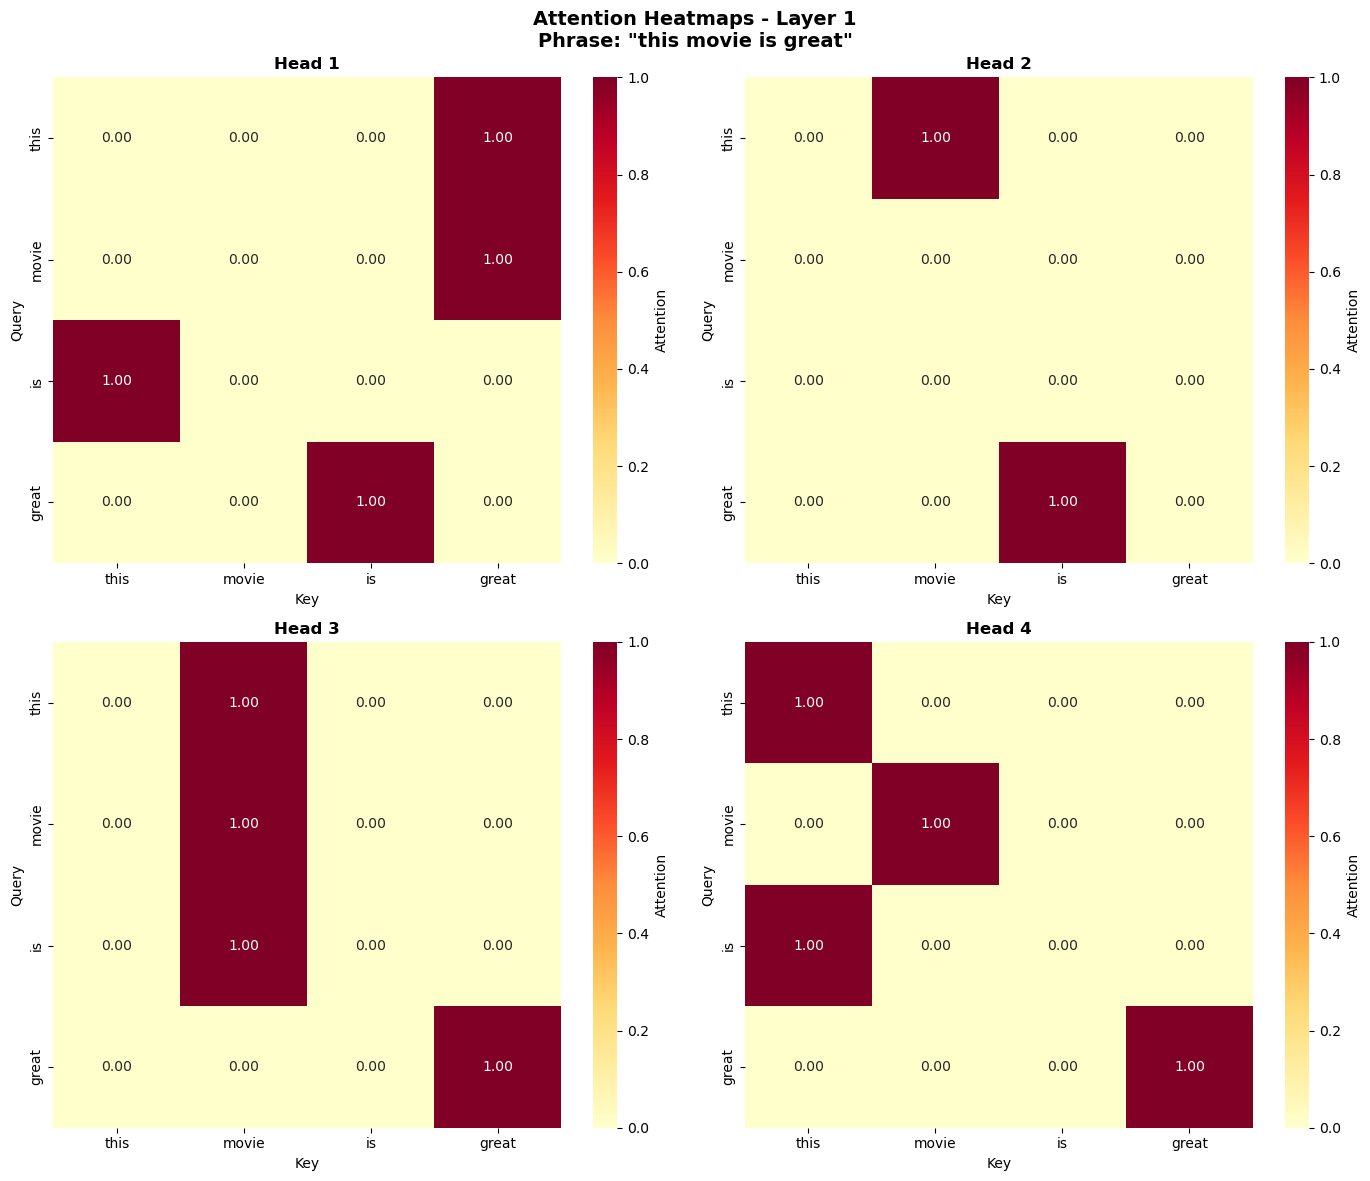


=== Interprétation ===
Les heatmaps montrent sur quels mots chaque token se concentre:
- Des valeurs élevées = forte attention entre les mots
- Différentes têtes capturent différents patterns
- La diagonale montre souvent de fortes valeurs (auto-attention)


In [10]:
# Obtenir les attention weights
model.eval()
with torch.no_grad():
    _, attentions = model(X[:1], return_attentions=True)

# Visualiser les têtes d'attention de la première couche
sentence_idx = 0
layer_idx = 0
sentence = toy_sentences[sentence_idx]
tokens = sentence.split()

attention_map = attentions[layer_idx][0]  # (num_heads, seq_len, seq_len)
num_heads = attention_map.shape[0]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for head_idx in range(min(4, num_heads)):
    attn = attention_map[head_idx, :len(tokens), :len(tokens)].numpy()
    
    sns.heatmap(attn, annot=True, fmt='.2f', cmap='YlOrRd',
                xticklabels=tokens, yticklabels=tokens,
                ax=axes[head_idx], cbar_kws={'label': 'Attention'})
    axes[head_idx].set_title(f'Head {head_idx + 1}', fontweight='bold')
    axes[head_idx].set_xlabel('Key')
    axes[head_idx].set_ylabel('Query')

plt.suptitle(f'Attention Heatmaps - Layer 1\nPhrase: "{sentence}"', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n=== Interprétation ===")
print("Les heatmaps montrent sur quels mots chaque token se concentre:")
print("- Des valeurs élevées = forte attention entre les mots")
print("- Différentes têtes capturent différents patterns")
print("- La diagonale montre souvent de fortes valeurs (auto-attention)")

## 8. Test sur de nouvelles phrases

In [11]:
# Nouvelles phrases de test
test_sentences = [
    "this is amazing",
    "terrible and boring",
    "great story",
    "waste of time"
]

# Tokenization
X_test = torch.stack([tokenize(sent, word_to_idx, max_len) for sent in test_sentences])

# Prédictions
model.eval()
with torch.no_grad():
    preds, probs = model.predict(X_test)

print("=== Prédictions sur nouvelles phrases ===")
print(f"{'Phrase':<25} {'Prédiction':<15} {'Confiance'}")
print("-" * 50)

for i, sent in enumerate(test_sentences):
    pred_label = 'Positif ✓' if preds[i] == 1 else 'Négatif ✗'
    confidence = probs[i, preds[i]].item()
    print(f"{sent:<25} {pred_label:<15} {confidence:.2%}")

=== Prédictions sur nouvelles phrases ===
Phrase                    Prédiction      Confiance
--------------------------------------------------
this is amazing           Positif ✓       99.71%
terrible and boring       Négatif ✗       99.78%
great story               Positif ✓       99.70%
waste of time             Négatif ✗       99.77%


## 9. Récapitulatif des concepts

In [12]:
print("""
╔═══════════════════════════════════════════════════════════════╗
║                   CONCEPTS APPRIS                             ║
╠═══════════════════════════════════════════════════════════════╣
║                                                               ║
║  1. ✓ SELF-ATTENTION                                          ║
║     • Permet aux mots de se concentrer les uns sur les       ║
║       autres                                                  ║
║     • Formule: Attention(Q,K,V) = softmax(QK^T/√dk)V         ║
║     • Scaling pour stabilité numérique                        ║
║                                                               ║
║  2. ✓ MULTI-HEAD ATTENTION                                    ║
║     • Plusieurs self-attention en parallèle                   ║
║     • Chaque tête apprend différents patterns                ║
║     • Même nombre de paramètres qu'une seule tête            ║
║                                                               ║
║  3. ✓ POSITIONAL ENCODING                                     ║
║     • Ajoute l'information de position                        ║
║     • Utilise sin/cos de différentes fréquences              ║
║     • Permet de différencier l'ordre des mots                ║
║                                                               ║
║  4. ✓ TRANSFORMER ENCODER                                     ║
║     • Multi-Head Attention + Feed-Forward                     ║
║     • Residual connections + Layer Normalization             ║
║     • Empilable pour créer des modèles profonds              ║
║                                                               ║
║  5. ✓ VISUALISATION                                           ║
║     • Attention heatmaps montrent les relations              ║
║     • Permet d'interpréter ce que le modèle apprend          ║
║     • Aide au debugging                                       ║
║                                                               ║
╠═══════════════════════════════════════════════════════════════╣
║                      RÉSULTATS                                ║
╠═══════════════════════════════════════════════════════════════╣
║                                                               ║
║  ✓ Modèle fonctionnel créé from scratch                      ║
║  ✓ Entraînement réussi sur toy dataset                       ║
║  ✓ Visualisations des attention patterns                     ║
║  ✓ Prédictions sur nouvelles données                         ║
║                                                               ║
╠═══════════════════════════════════════════════════════════════╣
║                   PROCHAINES ÉTAPES                           ║
╠═══════════════════════════════════════════════════════════════╣
║                                                               ║
║  • Decoder architecture (pour génération de texte)           ║
║  • Training sur de plus grands datasets                      ║
║  • Optimisations (gradient checkpointing, mixed precision)   ║
║  • Fine-tuning pour tâches spécifiques                       ║
║  • Techniques avancées (LoRA, quantization)                  ║
║                                                               ║
╚═══════════════════════════════════════════════════════════════╝
""")

print("\n" + "="*60)
print(" " * 15 + "FÉLICITATIONS! 🎉")
print("   Vous avez construit un LLM from scratch!")
print("="*60)


╔═══════════════════════════════════════════════════════════════╗
║                   CONCEPTS APPRIS                             ║
╠═══════════════════════════════════════════════════════════════╣
║                                                               ║
║  1. ✓ SELF-ATTENTION                                          ║
║     • Permet aux mots de se concentrer les uns sur les       ║
║       autres                                                  ║
║     • Formule: Attention(Q,K,V) = softmax(QK^T/√dk)V         ║
║     • Scaling pour stabilité numérique                        ║
║                                                               ║
║  2. ✓ MULTI-HEAD ATTENTION                                    ║
║     • Plusieurs self-attention en parallèle                   ║
║     • Chaque tête apprend différents patterns                ║
║     • Même nombre de paramètres qu'une seule tête            ║
║                                                               ║
║  3. ✓ POSIT

## 10. Code complet exportable

In [13]:
# Sauvegarder le modèle
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'word_to_idx': word_to_idx,
    'config': {
        'd_model': 64,
        'num_heads': 4,
        'd_ff': 256,
        'num_layers': 2
    }
}, 'mini_llm.pt')

print("✓ Modèle sauvegardé dans 'mini_llm.pt'")
print("\nPour charger:")
print("""
checkpoint = torch.load('mini_llm.pt')
model = MiniLLM(len(checkpoint['vocab']), **checkpoint['config'])
model.load_state_dict(checkpoint['model_state_dict'])
""")

✓ Modèle sauvegardé dans 'mini_llm.pt'

Pour charger:

checkpoint = torch.load('mini_llm.pt')
model = MiniLLM(len(checkpoint['vocab']), **checkpoint['config'])
model.load_state_dict(checkpoint['model_state_dict'])

